In [3]:
from ultralytics import YOLO
import numpy as np

In [3]:
model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)
results = model("https://ultralytics.com/images/bus.jpg",show = True)


100%|██████████| 131M/131M [02:20<00:00, 974kB/s]  



Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 C:\Users\MAY02\Desktop\Yolov8\bus.jpg: 640x480 5 buss, 4 boats, 2 traffic lights, 6 fire hydrants, 1 stop sign, 45 parking meters, 13 benchs, 8 cats, 3 dogs, 5 horses, 5 sheeps, 6 bears, 1 giraffe, 11 backpacks, 11 umbrellas, 27 handbags, 8 ties, 9 suitcases, 4 skiss, 52 snowboards, 2 baseball bats, 10 baseball gloves, 3 skateboards, 2 surfboards, 2 cups, 2 forks, 1 spoon, 1 banana, 1 apple, 5 sandwichs, 1 orange, 2 broccolis, 8 carrots, 2 hot dogs, 3 pizzas, 1 couch, 3 potted plants, 1 bed, 5 remotes, 15 keyboards, 1 refrigerator, 3 vases, 2131.2ms
Speed: 4.2ms preprocess, 2131.2ms inference, 9.6ms postprocess per image at shape (1, 3, 640, 480)


In [17]:
model = YOLO("bestYOLOV8x.pt")



In [49]:
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
cap = cv2.VideoCapture('0822.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use 'XVID', 'MJPG', etc.
fps = cap.get(cv2.CAP_PROP_FPS)  # Get the frames per second from the input video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, str(track_id), (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()



0: 384x640 14 fishs, 31.5ms
Speed: 3.0ms preprocess, 31.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 fishs, 4.5ms
Speed: 2.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 4.5ms
Speed: 2.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 38

In [52]:
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
cap = cv2.VideoCapture('0822 (1).mp4')

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, str(track_id), (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('YOLOv8 with DeepSORT Tracking', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 384x640 14 fishs, 34.1ms
Speed: 5.0ms preprocess, 34.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 fishs, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384,

In [43]:
dets[0][0]


[1292.0022, 493.17563, 68.98071, 173.72867, 0.774389]

In [32]:
tracks = tracker.update_tracks(dets, frame=frame)


TypeError: object of type 'numpy.float32' has no len()

In [ ]:
import csv
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2
import numpy as np

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
# cap = cv2.VideoCapture('0822.mp4')
cap = cv2.VideoCapture('FeMe-MaMos-MaMe-d2-5ng.MOV')


# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions of tracked objects
previous_positions = {}

# Store tracking data for CSV export
tracking_data = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate velocity if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement = np.linalg.norm(current_position - previous_position)  # Euclidean distance
                velocity = displacement * fps  # pixels per second
            else:
                velocity = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocity:.2f} px/s', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, velocity])

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('FeMe-MaMos-MaMe-d2-5ng_MOV.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (px/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 13 fishs, 35.5ms
Speed: 3.5ms preprocess, 35.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 4.5ms
Speed: 1.5ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 fishs, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 fishs, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 3.5ms
Speed: 2.4ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 8.7ms
Speed: 1.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 38

In [4]:
import csv
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2
import numpy as np

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
cap = cv2.VideoCapture('0822.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions, total distances, and tracking duration of tracked objects
previous_positions = {}
total_distances = {}
track_durations = {}

# Store tracking data for CSV export
tracking_data = []

# Define the scale: meters per pixel
scale_m_per_px = 0.05  # Example: 0.05 meters per pixel

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate distance if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement = np.linalg.norm(current_position - previous_position)  # Euclidean distance in pixels
                distance_m = displacement * scale_m_per_px  # Convert to meters
                
                # Update total distance
                if track_id in total_distances:
                    total_distances[track_id] += distance_m
                else:
                    total_distances[track_id] = distance_m
                
                # Update tracking duration (in seconds)
                track_durations[track_id] += 1 / fps
            else:
                total_distances[track_id] = 0
                track_durations[track_id] = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box and distance
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Dist: {total_distances[track_id]:.2f} m', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, total_distances[track_id]])

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking, Distance, and Average Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Calculate and print total distances and average velocities
for track_id, distance in total_distances.items():
    duration = track_durations[track_id]
    average_velocity = distance / duration if duration > 0 else 0
    print(f'Object ID {track_id} traveled {distance:.2f} meters with an average velocity of {average_velocity:.2f} m/s')

# Write tracking data to a CSV file
with open('tracking_data.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Total Distance (m)', 'Average Velocity (m/s)'])
    for data in tracking_data:
        track_id = data[1]
        duration = track_durations[track_id]
        average_velocity = total_distances[track_id] / duration if duration > 0 else 0
        csvwriter.writerow(data + [average_velocity])



0: 384x640 14 fishs, 33.1ms
Speed: 3.0ms preprocess, 33.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 fishs, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

In [10]:
real_world_distance_m = 3.0  # meters (e.g., known width of an object or distance)
pixel_distance_px = 600.0    # pixels (corresponding pixel width in the video)
scale_m_per_px = real_world_distance_m / pixel_distance_px 

In [12]:

(1327.00267672265 -1326.2885784183827)**2 + (578.6058920309875-579.8959863945496)**2

np.sqrt(2.174279855051972)*scale_m_per_px *100


0.737271974079439

In [14]:
import csv
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
cap = cv2.VideoCapture('0822.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions, total distances, and velocities of tracked objects
previous_positions = {}
total_distances = {}
velocities = {}

# Store tracking data for CSV export
tracking_data = []

# Scale factor (example values)
scale_m_per_px = 0.05  # Example: 0.05 meters per pixel

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate displacement and velocity if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement_px = np.linalg.norm(current_position - previous_position)  # Euclidean distance in pixels
                displacement_m = displacement_px * scale_m_per_px  # Convert to meters

                # Calculate velocity (m/s)
                velocity = displacement_m * fps

                # Update total distance
                if track_id in total_distances:
                    total_distances[track_id] += displacement_m
                else:
                    total_distances[track_id] = displacement_m
                
                # Update velocity
                velocities[track_id] = velocity
            else:
                total_distances[track_id] = 0
                velocities[track_id] = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box, distance, and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Dist: {total_distances[track_id]:.2f} m', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocities[track_id]:.2f} m/s', (int(bbox[0]), int(bbox[1])-60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, total_distances[track_id], velocities[track_id]])

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking, Distance, and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('tracking_data.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Total Distance (m)', 'Velocity (m/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 14 fishs, 33.8ms
Speed: 4.0ms preprocess, 33.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 fishs, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x

In [17]:
0.07372719740794391/((141-3))

0.000534255053680753

In [29]:
import pandas as pd

# Load the CSV file
file_path = 'tracking_data_.csv'  # Replace with the correct path to your CSV file
data = pd.read_csv(file_path)

# Remove the 'Velocity (m/s)' column
if 'Velocity (px/s)' in data.columns:
    data = data.drop(columns=['Velocity (px/s)'])
    

# Save the updated CSV file
output_file_path = 'tracking_data_updated_2.csv'
data.to_csv(output_file_path, index=False)

print(f"Updated file saved to {output_file_path}")


Updated file saved to tracking_data_updated_2.csv


In [32]:
data

,Frame,Object ID,X Center,Y Center
0,3.0,1,1327.002677,579.895986
1,3.0,2,1543.776369,959.311382
2,3.0,3,2293.203163,636.450904
3,3.0,4,1425.133149,914.888744
4,3.0,5,2203.429495,975.726356
...,...,...,...,...
1912,141.0,26,2016.530078,698.196716
1913,141.0,29,1569.724042,593.511028
1914,141.0,34,2417.800994,835.547096
1915,141.0,35,2033.715067,745.216971


In [9]:
import pandas as pd
import numpy as np

# Load the data (assuming the data is in a CSV file)
data = pd.read_csv('tracking_data.csv')

# Sort by object ID and frame number
data = data.sort_values(by=['Object ID', 'Frame'])

# Initialize an empty DataFrame for results
velocity_data = pd.DataFrame(columns=['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity'])

# Calculate velocities for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id].copy()
    
    # Calculate differences in X and Y coordinates between consecutive frames
    obj_data['X_diff'] = obj_data['X Center'].diff().fillna(0)
    obj_data['Y_diff'] = obj_data['Y Center'].diff().fillna(0)
    
    # Calculate the Euclidean distance (velocity) between frames
    obj_data['Velocity'] = np.sqrt(obj_data['X_diff']**2 + obj_data['Y_diff']**2)*((141-3)/4)*0.01
    
    # Append the results to the velocity_data DataFrame
    velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity']]])
    

# Group by object ID and check if velocities are different
def check_velocity_variation(group):
    velocities = group['Velocity'].values
    return len(set(velocities)) > 1

# Check each object ID for varying velocities
velocity_variation = velocity_data.groupby('Object ID').apply(check_velocity_variation)

# Filter object IDs with varying velocities
objects_with_varying_velocities = velocity_variation[velocity_variation].index

print("Object IDs with varying velocities:")
print(objects_with_varying_velocities.tolist())

# Optional: Save the filtered results to a CSV file
velocity_data.to_csv('velocity_per_frame.csv', index=False)


Object IDs with varying velocities:
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 16, 17, 18, 20, 21, 22, 23, 24, 26, 29, 30, 34, 35, 36]


C:\Users\MAY02\AppData\Local\Temp\ipykernel_5416\1727662791.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  velocity_data = pd.concat([velocity_data, obj_data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity']]])
C:\Users\MAY02\AppData\Local\Temp\ipykernel_5416\1727662791.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  velocity_variation = velocity_data.groupby('Object ID').apply(check_velocity_variation)


In [35]:
1/((141-3)/4)

0.028985507246376812

In [13]:
data = pd.read_csv('velocity_per_frame.csv')


In [4]:
np.sqrt((1327.00267672265-1326.2885784183827)**2+ (579.8959863945496 -578.6058920309875)**2)

1.474543948158878

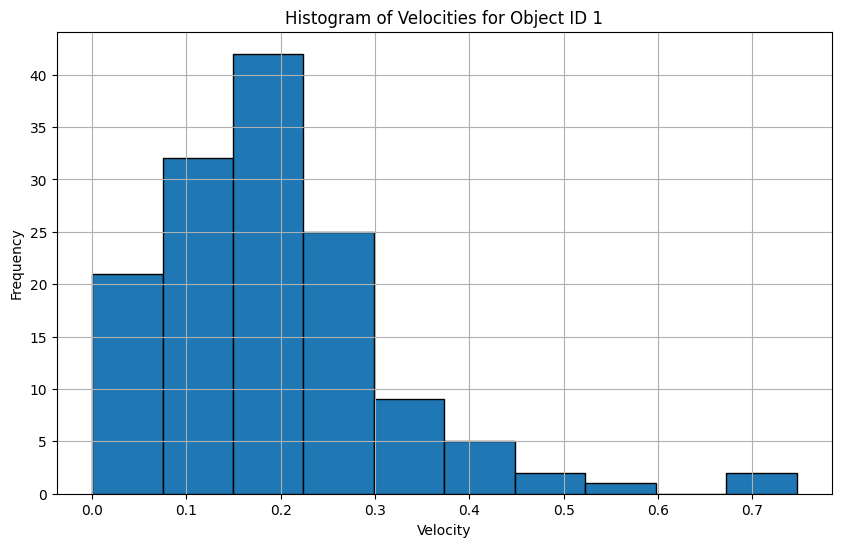

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your data in a pandas DataFrame named 'data'
# data = pd.read_csv('your_data_file.csv')  # Load your data file

# Filter data for Object ID 1
obj_data = data[data['Object ID'] == 1]

# Plot histogram of velocities
plt.figure(figsize=(10, 6))
plt.hist(obj_data['Velocity'], bins=10, edgecolor='black')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Velocities for Object ID 1')
plt.grid(True)
plt.show()


In [18]:
obj_data['Velocity'].mean()

0.1905700338329125

In [21]:
import pandas as pd

# Load your data
data = pd.read_csv('velocity_per_frame.csv')

# Create a list to collect average velocity data
average_velocity_list = []

# Calculate average velocity for each object ID
for object_id in data['Object ID'].unique():
    # Filter data for the current object
    obj_data = data[data['Object ID'] == object_id]
    
    # Calculate the average velocity
    average_velocity = obj_data['Velocity'].mean()
    
    # Append the result to the list
    average_velocity_list.append({
        'Object ID': object_id,
        'Average_Velocity': average_velocity
    })

# Convert the list to a DataFrame
average_velocity_data = pd.DataFrame(average_velocity_list)

# Save the results to a CSV file if needed
average_velocity_data.to_csv('average_velocity_per_object.csv', index=False)

print(average_velocity_data)


    Object ID  Average_Velocity
0           1          0.190570
1           2          0.722917
2           3          0.816602
3           4          1.208691
4           5          1.295811
5           6          0.526961
6           7          0.515835
7           9          0.733320
8          10          0.488926
9          11          0.243483
10         12          1.562565
11         16          1.264547
12         17          1.851422
13         18          0.629453
14         20          1.191458
15         21          0.330725
16         22          0.747379
17         23          1.700530
18         24          1.171830
19         26          1.488803
20         29          1.925161
21         30          1.895457
22         34          1.823662
23         35          1.257002
24         36          5.454111


In [22]:
139/4

34.75

In [39]:
obj_data = data[data['Object ID'] == 25]
obj_data

,Frame,Object ID,X Center,Y Center,Velocity


In [43]:
import csv
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2

# Load YOLOv8 model
model = YOLO('bestYOLOV8x.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# Load video
cap = cv2.VideoCapture('0822.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height))

# Store the previous positions, total distances, and velocities of tracked objects
previous_positions = {}
total_distances = {}
velocities = {}

# Store tracking data for CSV export
tracking_data = []

# Scale factor (example values)
scale_m_per_px = 0.05  # Example: 0.05 meters per pixel

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)
    detections = results[0].boxes.data

    # Prepare detections for DeepSORT
    dets = []
    for box in detections:
        x1, y1, x2, y2, conf, cls = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1
        dets.append([[x1, y1, width, height], conf])

    # Update tracker with detections
    tracks = tracker.update_tracks(dets, frame=frame)

    # Draw tracking results on the frame
    for track in tracks:
        if track.is_confirmed():
            track_id = track.track_id
            bbox = track.to_tlbr()
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            current_position = np.array([x_center, y_center])

            # Calculate displacement and velocity if we have previous position
            if track_id in previous_positions:
                previous_position = previous_positions[track_id]
                displacement_px = np.linalg.norm(current_position - previous_position)  # Euclidean distance in pixels
                displacement_m = displacement_px * scale_m_per_px  # Convert to meters

                # Calculate velocity (m/s)
                velocity = displacement_m * fps

                # Update total distance
                if track_id in total_distances:
                    total_distances[track_id] += displacement_m
                else:
                    total_distances[track_id] = displacement_m
                
                # Update velocity
                velocities[track_id] = velocity
            else:
                total_distances[track_id] = 0
                velocities[track_id] = 0

            # Update previous position
            previous_positions[track_id] = current_position

            # Draw bounding box, distance, and velocity
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Dist: {total_distances[track_id]:.2f} m', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f'Vel: {velocities[track_id]:.2f} m/s', (int(bbox[0]), int(bbox[1])-60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            # Append tracking data to the list for CSV export
            tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, total_distances[track_id], velocities[track_id]])

    # Write the frame to the output video file
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow('YOLOv8 with DeepSORT Tracking, Distance, and Velocity', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

# Write tracking data to a CSV file
with open('tracking_data_strongsort.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Total Distance (m)', 'Velocity (m/s)'])
    csvwriter.writerows(tracking_data)



0: 384x640 14 fishs, 32.2ms
Speed: 4.0ms preprocess, 32.2ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 3.5ms
Speed: 2.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 fishs, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 fishs, 14.4ms
Speed: 2.0ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


In [44]:
data_1 = pd.read_csv('tracking_data_1fps.csv')


In [47]:
len(data_1['Frame'].unique())

119